# Notebook to generate some features by applying clustering techniques.

Table of contents <a id='top'>

1. [EDA](#eda)
2. [Clustering Algorithms](#clustering)

    2.1. [K - Means](#kmeans)
    
    2.2. [Hierarchical (Ward)](#ward)
    
    2.3. [GMM](#gmm)
    
    2.4. [DBSCAN](#dbscan)

In [18]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Get the data
X_train, X_test, y_train, y_test, encoder = sd.get_success_data()

## 1. EDA <a id='eda'/>
[Top](#top)

In [20]:
X_train.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_social,channel_mobile,channel_email
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0


In [21]:
customer_feats = ['age', 'gender', 'income', 'missing_demographics', 
                  'member_epoch_days']
offer_feats = ['difficulty', 'duration', 'offer_type', 'reward_t', 
               'channel_web', 'channel_social', 'channel_mobile', 
               'channel_email']

The interesting clustering is in the customers, as the offers are very few.

In [23]:
X_train_tr = encoder.fit_transform(X_train)
cust_train = X_train_tr[customer_feats]
print(cust_train.shape)
cust_train.head()

(50808, 5)


,age,gender,income,missing_demographics,member_epoch_days
0,33.0,1.0,72000.0,0,17277
1,33.0,1.0,72000.0,0,17277
2,33.0,1.0,72000.0,0,17277
5,NaN,NaN,NaN,1,17646
7,40.0,2.0,57000.0,0,17540


In [24]:
cust_train.isnull().mean()

age                     0.128326
gender                  0.128326
income                  0.128326
missing_demographics    0.000000
member_epoch_days       0.000000
dtype: float64

Let's drop the missing data for clustering (it's only 13% of the dataset, and imputing the missing data could generate new, artificial clusters, or distort the current ones). Also let's drop the duplicates.

In [27]:
unique_train = cust_train.dropna().drop_duplicates().drop(
    'missing_demographics', axis=1)
print(unique_train.shape)
unique_train.head()

(14748, 4)


,age,gender,income,member_epoch_days
0,33.0,1.0,72000.0,17277
7,40.0,2.0,57000.0,17540
12,59.0,0.0,90000.0,16864
17,24.0,0.0,60000.0,17116
21,26.0,0.0,73000.0,17338


### Let's scale the features

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaler.fit(unique_train)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [34]:
X_s_train = pd.DataFrame(scaler.transform(unique_train),
                         index=unique_train.index,
                         columns=unique_train.columns)
X_s_train.head()

/Users/antelinvestigacionydesarrollo/anaconda3/envs/sbucks/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,age,gender,income,member_epoch_days
0,-1.230638,0.769453,0.305519,0.146978
7,-0.827994,2.699367,-0.388848,0.774266
12,0.264895,-1.160461,1.138758,-0.838078
17,-1.748323,-1.160461,-0.249974,-0.237027
21,-1.633281,-1.160461,0.351810,0.292471


### Let's get some general visualization of the dataset

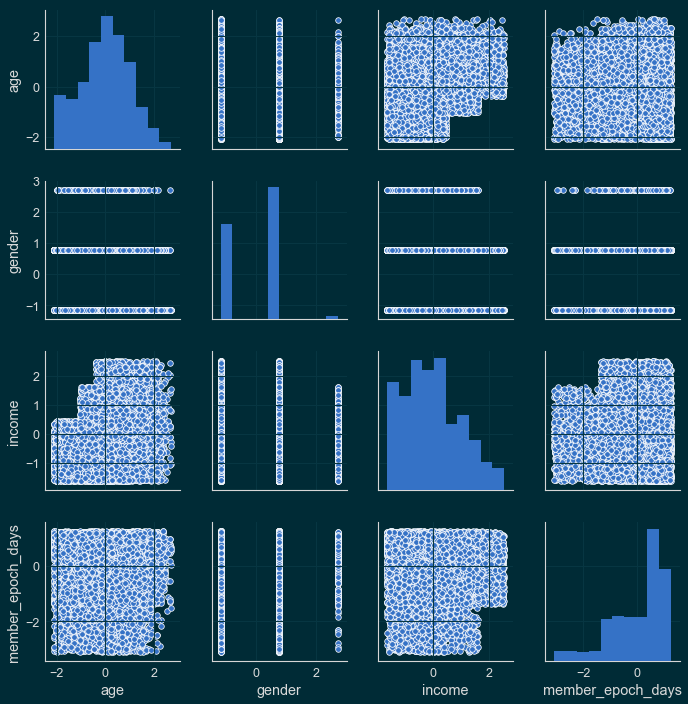

In [56]:
sns.pairplot(X_s_train)

There are some "artificial" stair-like shapes in the income-age plot, and also in the income-member_epoch_days plot. The thresholds could define clusters...

### Let's use PCA to visualize the dataset in 2D

In [35]:
from sklearn.decomposition import PCA

In [80]:
def pca_visualize(X, **kwargs):
    """ Applies PCA to get 2-D data and make a scatter plot."""
    extractor = PCA(n_components=2)
    X_pca = extractor.fit_transform(X)
    
    print('Explained variance ratio for the first two components: {}'.format(
        extractor.explained_variance_ratio_.sum()))
    
    plt.scatter(X_pca[:,0], X_pca[:,1], **kwargs)
    plt.title('PCA scatter plot')
    plt.xlabel('PCA 1')
    _ = plt.ylabel('PCA 2')

Explained variance ratio for the first two components: 0.6148986186536066


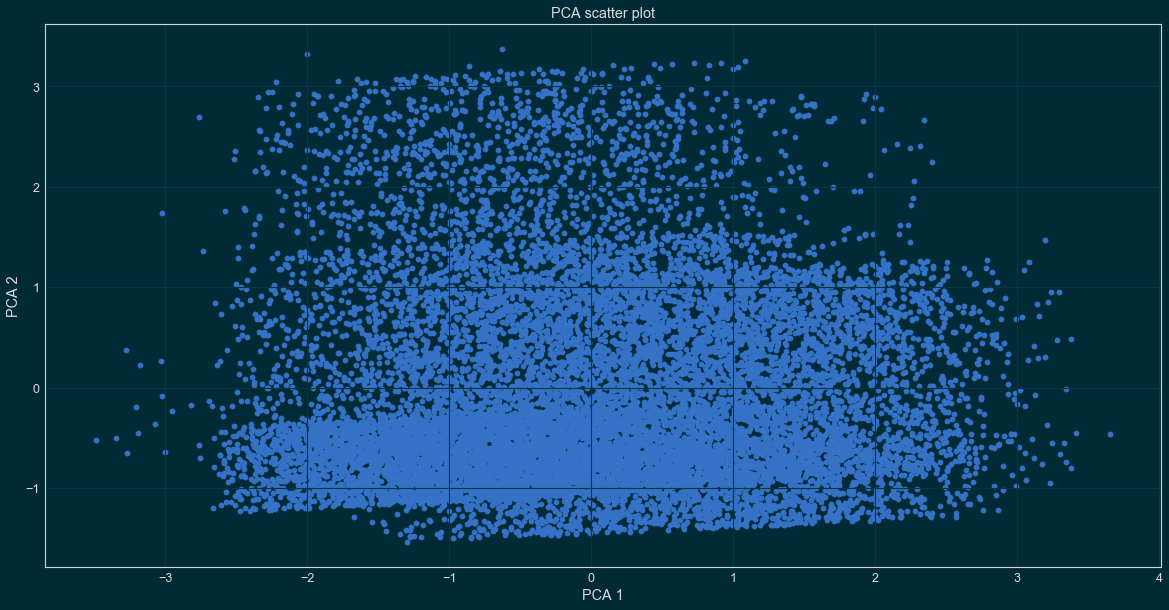

In [81]:
pca_visualize(X_s_train)

The 2-D representation looks good for GMM or DBSCAN. In next sections some clustering algorithms will be tested.

## 2. Validation Indexes <a id='indexes'/>
[Top](#top)

For comparing the models and validation, I will use the Silhouette score, and DBCV (Density Based Clustering Validation). As the main objective of this notebook is to get some new features, I will keep the clustering indexes of the methods that yield the best score in each of the metrics. I could also keep the best sample of each algorithm.

DBCV was implemented here: https://github.com/christopherjenness/DBCV

Let's try that library.

In [107]:
import DBCV
from scipy.spatial.distance import euclidean

In [108]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)

In [112]:
# %time DBCV.DBCV(X_s_train.values, cluster_labels, euclidean)

Running that function for validation takes too long. I will only use the Silhouette score, and BIC in the case of GMM. Also the elbow method, and some visualizations with PCA

## 3. Clustering algorithms <a id='clustering'/>
[Top](#top)

### 3.1. K - Means <a id='kmeans'/>
[Top](#top)

In [75]:
from sklearn.cluster import KMeans

In [101]:
kmeans = KMeans(n_clusters=4)
%time kmeans.fit(X_s_train)

CPU times: user 564 ms, sys: 8.21 ms, total: 572 ms
Wall time: 344 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [102]:
cluster = kmeans.predict(X_s_train)

In [103]:
def pca_visualize_clusters(X, cluster):
    """ Visualize all the clusters using PCA. """
    for c in np.unique(cluster):
        pca_visualize(X[cluster == c], label='cluster {}'.format(c))
    plt.legend()

Explained variance ratio for the first two components: 0.7391306007714609
Explained variance ratio for the first two components: 0.7052429144510345
Explained variance ratio for the first two components: 0.7528315484503814
Explained variance ratio for the first two components: 0.5954612976623002


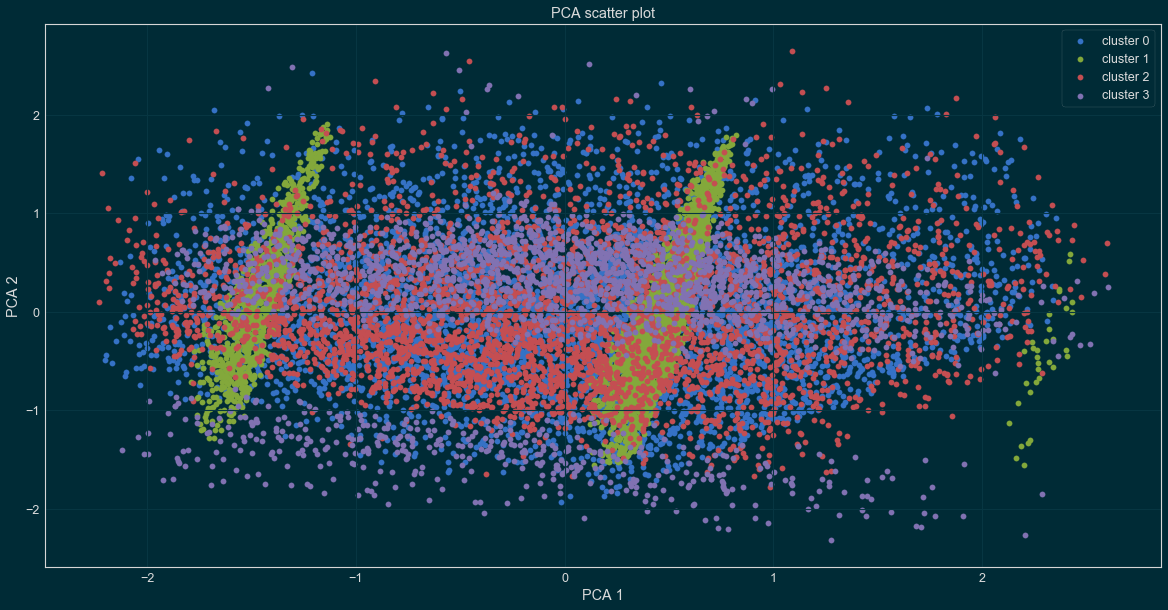

In [113]:
pca_visualize_clusters(X_s_train, cluster)

The visualization is not too informative. Let's use the Silhouette score to determine the best number of clusters.

In [123]:
from sklearn.metrics import silhouette_score
from time import time

In [135]:
def validate_clustering(X, clustering_algo, clusters):
    """ Get the Silhouette score and """
    silhouette = list()
    error = list()
    for i, n_clusters in enumerate(clusters):
        tic = time()
        method = clustering_algo(n_clusters=n_clusters)
        labels = method.fit_predict(X)
        silhouette.append(silhouette_score(X, labels))
        error.append(method.inertia_)
        toc = time()
        print('Algorithm {} of {} finished in {} seconds.'.format(
             i + 1, len(clusters), (toc - tic)))
    
    best_silhouette_n = clusters[np.argmax(silhouette)]
    print('The best Silhouette score is for {} clusters, and its value is: {}'.format(
        best_silhouette_n, max(silhouette)))
    print('The error for {} clusters is: {}'.format(
        best_silhouette_n, error[np.argmax(silhouette)]))
    
    plt.plot(clusters, silhouette)
    plt.title('Silhouette score')
    plt.vlines(best_silhouette_n, min(silhouette), max(silhouette), 'r')
    plt.figure()
    plt.plot(clusters, error)
    plt.title('Error')
    plt.vlines(best_silhouette_n, min(error), max(error), 'r')
    
    return silhouette, error, best_silhouette_n

Algorithm 1 of 28 finished in 4.284408092498779 seconds.
Algorithm 2 of 28 finished in 4.208032131195068 seconds.
Algorithm 3 of 28 finished in 4.126459360122681 seconds.
Algorithm 4 of 28 finished in 4.198612213134766 seconds.
Algorithm 5 of 28 finished in 4.277392148971558 seconds.
Algorithm 6 of 28 finished in 4.505926847457886 seconds.
Algorithm 7 of 28 finished in 4.9378392696380615 seconds.
Algorithm 8 of 28 finished in 4.835433006286621 seconds.
Algorithm 9 of 28 finished in 5.298961877822876 seconds.
Algorithm 10 of 28 finished in 5.039788007736206 seconds.
Algorithm 11 of 28 finished in 5.462141036987305 seconds.
Algorithm 12 of 28 finished in 6.666074275970459 seconds.
Algorithm 13 of 28 finished in 5.834595203399658 seconds.
Algorithm 14 of 28 finished in 6.008177995681763 seconds.
Algorithm 15 of 28 finished in 6.308326244354248 seconds.
Algorithm 16 of 28 finished in 6.268551826477051 seconds.
Algorithm 17 of 28 finished in 5.939279079437256 seconds.
Algorithm 18 of 28 fin

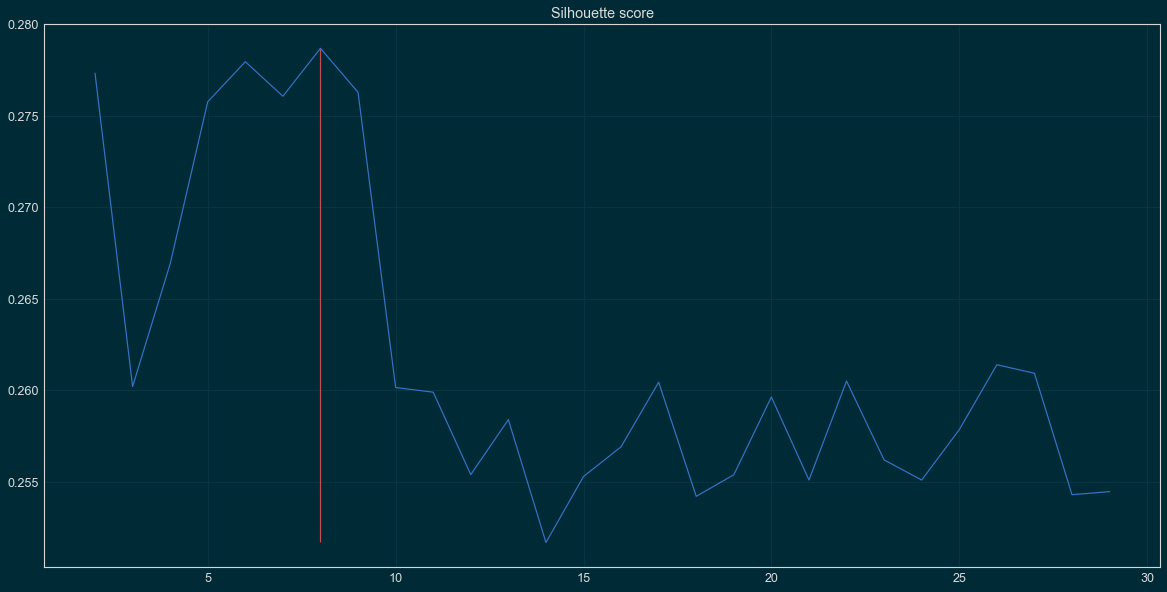

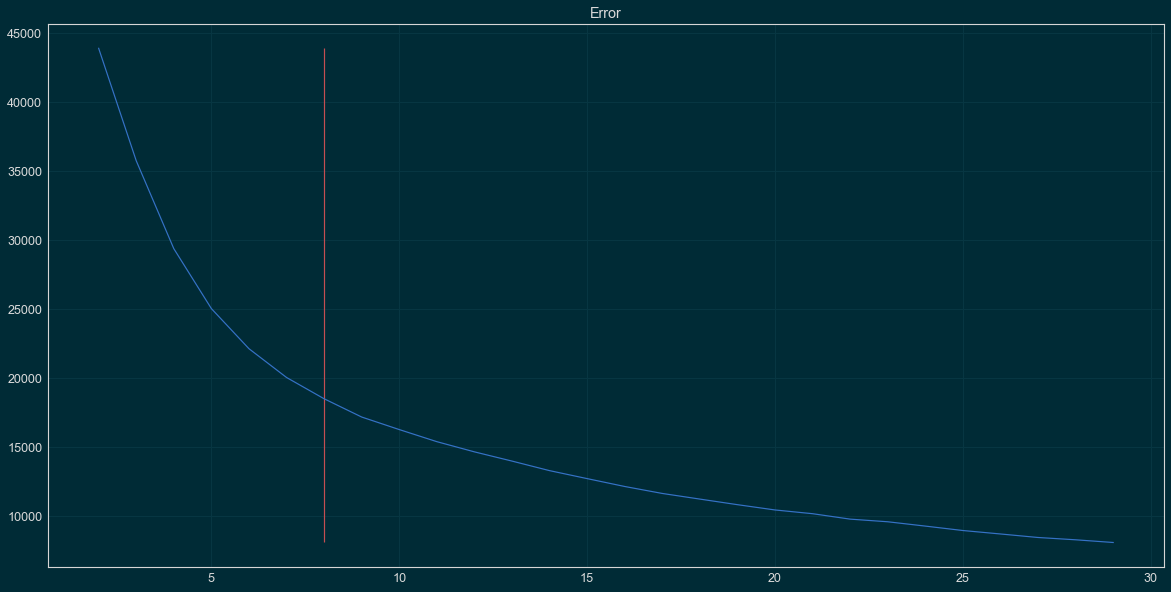

In [138]:
clusters = range(2, 30)
silhouette, error, best_n = validate_clustering(X_s_train, KMeans, clusters)

OK, let's use KMeans with n = 8

Explained variance ratio for the first two components: 0.8431121831977408
Explained variance ratio for the first two components: 0.7126638939409901
Explained variance ratio for the first two components: 0.6784514132642067
Explained variance ratio for the first two components: 0.6808641537847718
Explained variance ratio for the first two components: 0.7887587962574428
Explained variance ratio for the first two components: 0.7308916699002012
Explained variance ratio for the first two components: 0.7409355549847698
Explained variance ratio for the first two components: 0.6809861064957048


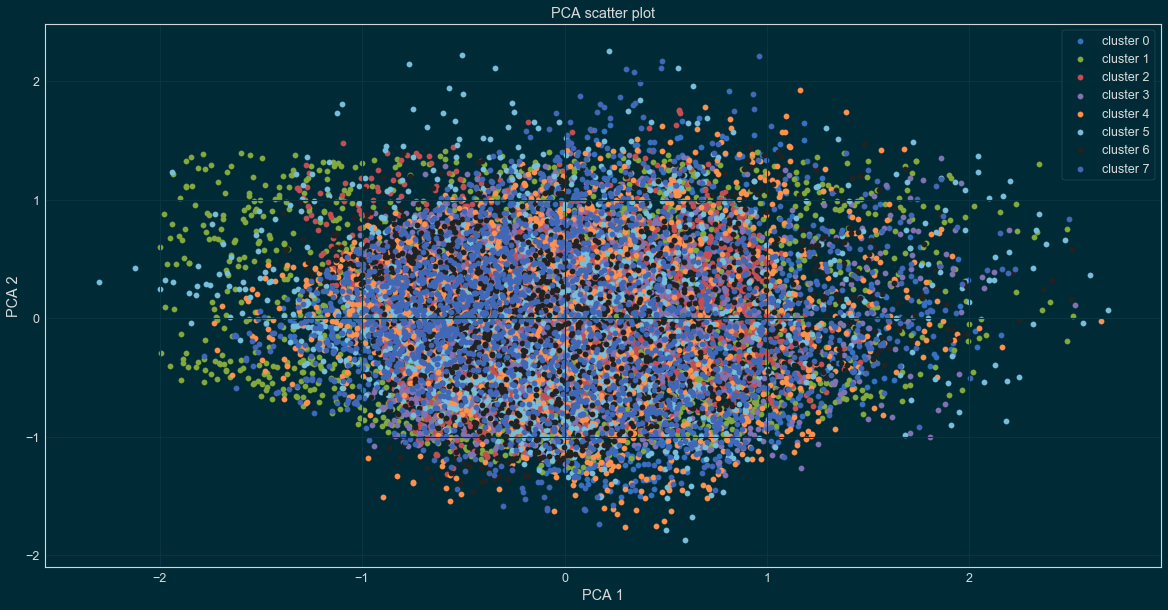

In [164]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)
pca_visualize_clusters(X_s_train, cluster_labels)

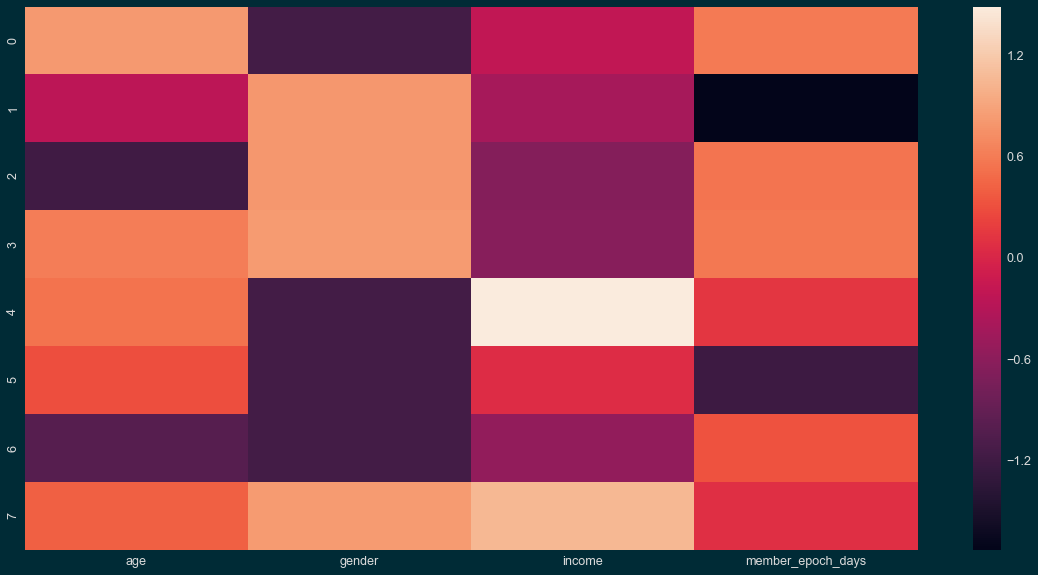

In [176]:
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

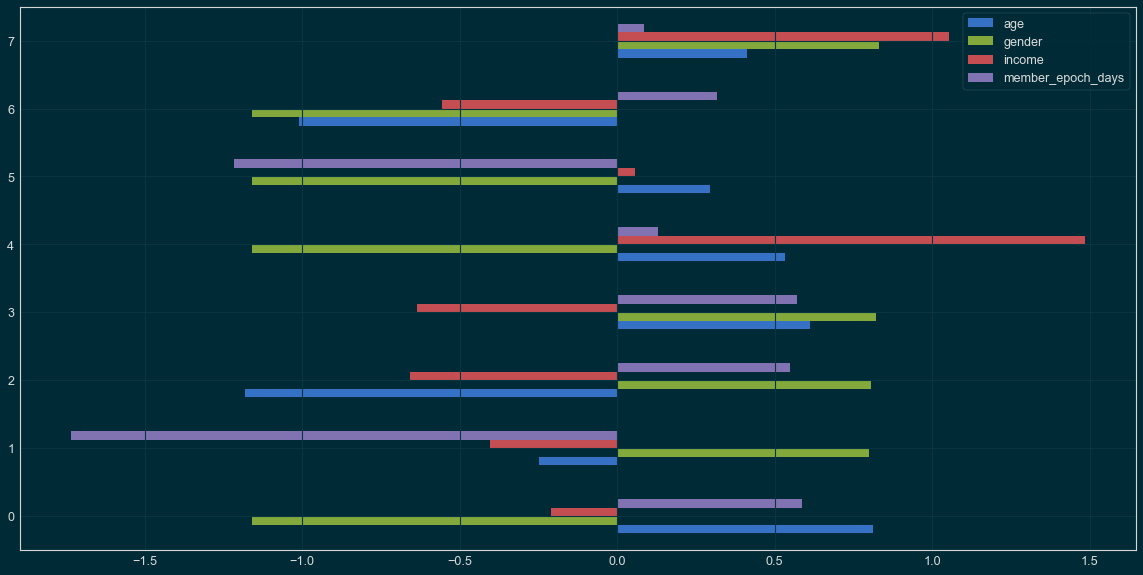

In [177]:
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

In [178]:
X_s_train.gender.unique()

array([ 0.76945298,  2.69936669, -1.16046072])

**Description of the clusters:**

 - 0) Old age, female, medium to low income, recent member.
 - 1) Very early member, male, medium to low income, medium age.
 - 2) 
 

Text(0.5, 1.0, 'Number of members per cluster')

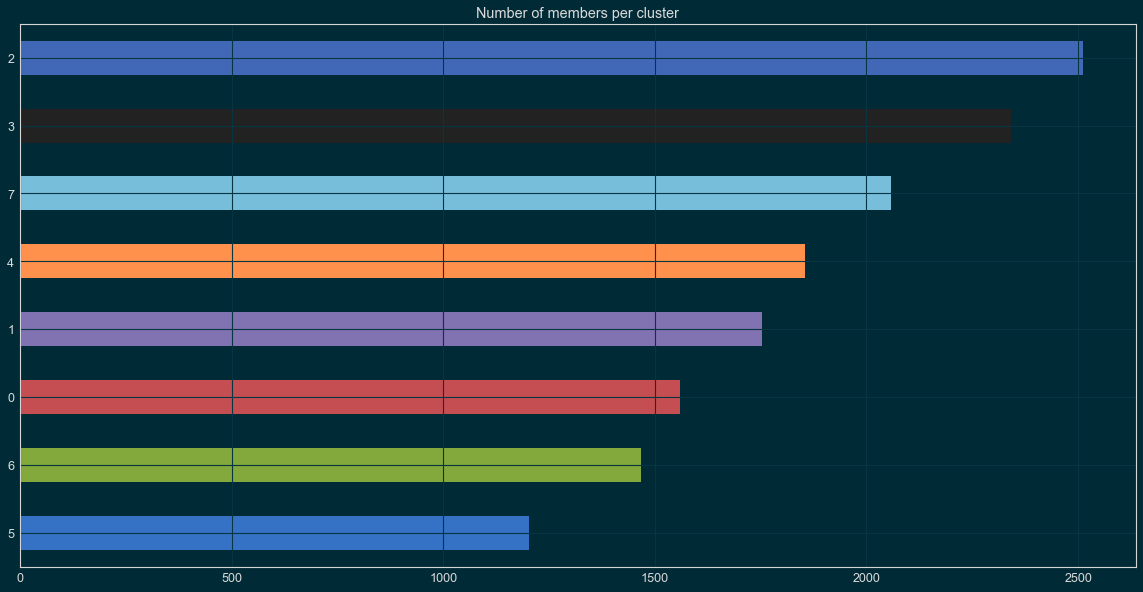

In [175]:
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

In [170]:
for label in range(n_clusters):
    X_clust = X_s_train[cluster_labels == label]
    print('Cluster {}'.format(label))
    print(X_clust.describe())
    print('-'*100)

Cluster 0
               age        gender       income  member_epoch_days
count  1559.000000  1.559000e+03  1559.000000        1559.000000
mean      0.812503 -1.160461e+00    -0.210067           0.585903
std       0.663226  2.221159e-16     0.659273           0.424037
min      -0.310310 -1.160461e+00    -1.638707          -0.847619
25%       0.264895 -1.160461e+00    -0.643449           0.389069
50%       0.725060 -1.160461e+00    -0.111101           0.645470
75%       1.242744 -1.160461e+00     0.351810           0.903063
max       2.680757 -1.160461e+00     0.953594           1.246521
----------------------------------------------------------------------------------------------------
Cluster 1
               age       gender       income  member_epoch_days
count  1754.000000  1754.000000  1754.000000        1754.000000
mean     -0.247444     0.800261    -0.403706          -1.735511
std       0.913490     0.304198     0.693996           0.719685
min      -2.093446    -1.160461    -1.

### 3.2. Hierarchical (Ward) <a id='ward'/>
[Top](#top)

### 3.3. GMM <a id='gmm'/>
[Top](#top)

### 3.4. DBSCAN <a id='dbscan'/>
[Top](#top)